<p>
<img src="http://www.cerm.unifi.it/chianti/images/logo%20unifi_positivo.jpg" 
        alt="UniFI logo" style="float: left; width: 20%; height: 20%;">
<div align="right">
Massimo Nocentini<br>
<small>
<br>December 7, 2016: CLT
<br>November 15, 2016: class
</small>
</div>
</p>
<br>
<br>
<div align="center">
<b>Abstract</b><br>
Lecture notes of today (November 15, 2016) class in Python, about simulation applied to Quicksort's checks and swaps.
</div>

In [1]:
from sympy import *
from sympy import stats
from numpy import linspace
import sys

from random import shuffle

from itertools import permutations
from statistics import mean, variance
from collections import namedtuple
from functools import wraps

sys.setrecursionlimit(10000000)

init_printing()

In [2]:
t, m, i, k, n, z = symbols('t m i k n z')
a, b = IndexedBase('a'), IndexedBase('b')

# Quicksort

In [3]:
CountData = namedtuple('CountData', ['checks', 'swaps'])

def counting(quicksort):
    
    @wraps(quicksort)
    def instrumented(array, counting_data=True):

        checks, swaps = 0, 0

        def check_handler(index, pivot):
            nonlocal checks
            checks += 1

        def swap_handler(index, pivot):
            nonlocal swaps
            swaps += 1

        sorted_array = quicksort(array, check_handler, swap_handler)
        return (sorted_array, CountData(checks, swaps)) if counting_data else sorted_array
    
    return instrumented

In [4]:
@counting
def quicksort(array, 
              check_performed=lambda index, pivot: None,
              swap_performed=lambda i, j: None):
    
    def rec(v):
        
        if not v: return v

        p = v[-1]
        i, j = -1, len(v)-1

        while i < j:

            i += 1
            check_performed(index=i, pivot=p)
            while v[i] < p: 
                check_performed(index=i, pivot=p)
                i += 1
            
            j -= 1
            check_performed(index=j, pivot=p)
            while 0 <= j and v[j] > p: 
                check_performed(index=j, pivot=p)
                j -= 1
                
            if i < j: 
                v[i], v[j] = v[j], v[i]
                swap_performed(i, j)

        v[i], v[-1] = v[-1], v[i] # discard this swap from counting

        return rec(v[:i]) + [p] + rec(v[i+1:])

    return rec(list(array))
    

In [5]:
array = list(range(10))
shuffle(array)
array

In [6]:
quicksort(array, counting_data=False)

In [7]:
array

In [8]:
sorted_array, data = quicksort(array, counting_data=True)

In [9]:
data.__str__()

'CountData(checks=50, swaps=4)'

In [10]:
assert sorted_array == sorted(array)

In [11]:
array

theoretical closed forms for the number of checks and swaps, _in the average case_:

In [12]:
def C(n):
    return 2*(n+1)*(harmonic(n+1)-1) if n else 0

def S(n):
    return 1/Integer(3)*(n+1)*(harmonic(n+1)-Integer(7)/3)+Integer(1)/2 if n > 1 else 0

In [13]:
StatData = namedtuple('StatData', ['mean', 'variance', 'sample_size'])

def simulation(f):
    
    @wraps(f)
    def simulated(*args, **kwds):
        
        arrays = f(*args, **kwds)
        
        all_checks, all_swaps = [], []
        for sarray, (checks, swaps) in map(quicksort, arrays):
            all_checks.append(checks)
            all_swaps.append(swaps)

        # means
        checks_mean_observed, swaps_mean_observed = mean(all_checks), mean(all_swaps)
        
        # variance
        checks_var_observed, swaps_var_observed = variance(all_checks), variance(all_swaps)
        
        N = len(list(arrays))
        return (StatData(checks_mean_observed, checks_var_observed, N), 
                StatData(swaps_mean_observed, swaps_var_observed, N))
        

    return simulated

In [14]:
help(mean)

Help on function mean in module statistics:

mean(data)
    Return the sample arithmetic mean of data.
    
    >>> mean([1, 2, 3, 4, 4])
    2.8
    
    >>> from fractions import Fraction as F
    >>> mean([F(3, 7), F(1, 21), F(5, 3), F(1, 3)])
    Fraction(13, 21)
    
    >>> from decimal import Decimal as D
    >>> mean([D("0.5"), D("0.75"), D("0.625"), D("0.375")])
    Decimal('0.5625')
    
    If ``data`` is empty, StatisticsError will be raised.



In [24]:
help(variance)

Help on function variance in module statistics:

variance(data, xbar=None)
    Return the sample variance of data.
    
    data should be an iterable of Real-valued numbers, with at least two
    values. The optional argument xbar, if given, should be the mean of
    the data. If it is missing or None, the mean is automatically calculated.
    
    Use this function when your data is a sample from a population. To
    calculate the variance from the entire population, see ``pvariance``.
    
    Examples:
    
    >>> data = [2.75, 1.75, 1.25, 0.25, 0.5, 1.25, 3.5]
    >>> variance(data)
    1.3720238095238095
    
    If you have already calculated the mean of your data, you can pass it as
    the optional second argument ``xbar`` to avoid recalculating it:
    
    >>> m = mean(data)
    >>> variance(data, m)
    1.3720238095238095
    
    This function does not check that ``xbar`` is actually the mean of
    ``data``. Giving arbitrary values for ``xbar`` may lead to invalid or
   

## simulation: `all_permutations`

In [15]:
n = 4
perms = list(permutations(range(n)))
assert len(perms) == factorial(n)

perms

In [16]:
@simulation
def all_permutations(n):
    return [list(perm) for perm in permutations(range(n))]

In [17]:
n = 5
checks_stat_data, swaps_stat_data = all_permutations(n)

In [18]:
print(checks_stat_data)

StatData(mean=17.4, variance=1.8554621848739496, sample_size=120)


In [19]:
print(swaps_stat_data)

StatData(mean=0.7333333333333333, variance=0.365266106442577, sample_size=120)


In [20]:
(checks_mean, _, N), (swaps_mean, _, _) = checks_stat_data, swaps_stat_data

assert C(n) == checks_mean and S(n) == swaps_mean and N == factorial(n)

## simulation: `random_permutations`

In [21]:
@simulation
def random_permutations(n, N):
    
    perm = list(range(n))
    
    perms = []
    
    for i in range(N):
        shuffle(perm)
        perms.append(list(perm))
    
    return perms

In [22]:
n = 8
checks_stat_data, swaps_stat_data = random_permutations(8, 8000)

In [23]:
print(checks_stat_data)

StatData(mean=32.92025, variance=8.028393486685836, sample_size=8000)


In [24]:
print(swaps_stat_data)

StatData(mean=1.98375, variance=0.7925850106263284, sample_size=8000)


In [25]:
n = 8
print('n!={} -> true checks mean: {:.5f}\ttrue swaps mean: {:.5f}\n'.format(
        factorial(n), C(n).evalf(), S(n).evalf()))

for N in range(1000, 8001, 500):
    (checks_mean, _, _), (swaps_mean, _, _) = random_permutations(n, N)
    print('N={} -> observed checks mean: {:.5f}\tobserved swaps mean: {:.5f}'.format(N, checks_mean, swaps_mean))

n!=40320 -> true checks mean: 32.92143	true swaps mean: 1.98690

N=1000 -> observed checks mean: 32.91300	observed swaps mean: 2.00500
N=1500 -> observed checks mean: 33.00733	observed swaps mean: 1.94200
N=2000 -> observed checks mean: 33.01450	observed swaps mean: 1.99250
N=2500 -> observed checks mean: 32.96200	observed swaps mean: 1.95920
N=3000 -> observed checks mean: 32.88000	observed swaps mean: 1.99033
N=3500 -> observed checks mean: 32.99829	observed swaps mean: 1.99543
N=4000 -> observed checks mean: 32.90825	observed swaps mean: 1.99775
N=4500 -> observed checks mean: 32.92133	observed swaps mean: 1.98267
N=5000 -> observed checks mean: 32.87180	observed swaps mean: 1.99180
N=5500 -> observed checks mean: 32.92364	observed swaps mean: 1.98745
N=6000 -> observed checks mean: 32.86167	observed swaps mean: 1.99967
N=6500 -> observed checks mean: 32.86738	observed swaps mean: 1.99262
N=7000 -> observed checks mean: 32.93043	observed swaps mean: 2.00229
N=7500 -> observed checks

In [26]:
dim, step = 100, 10
res = {i: random_permutations(i, i*step) for i in range(step, dim+1, step)}

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

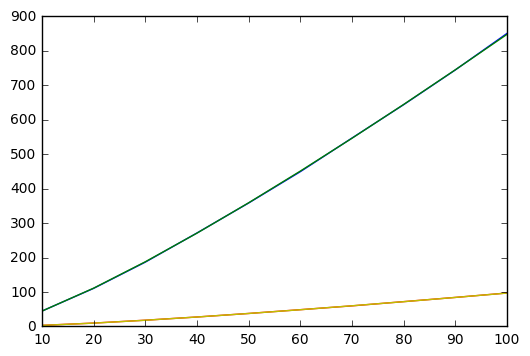

In [28]:
domain = sorted(res.keys())
plt.plot(domain, [res[k][0].mean for k in domain], 'b',
         domain, [C(n) for n in domain], 'g',
         domain, [res[k][1].mean for k in domain], 'r',
         domain, [S(n) for n in domain], 'y')
None

## CLT

In [30]:
def draw_frequencies_histogram(seq, bins, normed=None, pdf=None):
    
    if callable(pdf):
        normed=True
        domain, theo_fn = pdf(seq)
        plt.plot(domain, [theo_fn(i) for i in domain], 'b')
    
    n, bins, patches = plt.hist(list(seq), bins, normed=normed, facecolor='green', alpha=0.5)
    
    plt.grid(True)
    plt.show()

In [31]:
def Normal_distribution(z, mean, std):
    Normal_rv = stats.Normal(symbols('x'), mean, std)
    pdf = stats.density(Normal_rv)
    return Lambda([z], pdf(z))

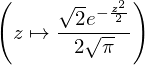

In [32]:
Normal_fn = Normal_distribution(z, 0, 1)
Normal_fn

In [33]:
n, N, samples = 8, 1000, 1000

checks_stats, swaps_stats = [], []

for i in range(samples):
    csd, ssd = random_permutations(n, N)
    checks_stats.append(csd)
    swaps_stats.append(ssd)

According to the [Central Limit Theorem][clt], classical interpretation, a "big" sample is distributed as follows:

$$
\sqrt{\frac{n}{\sigma_{n}}}\left(\bar{X}_{n} - \mu\right) \stackrel{d}{\sim} \mathcal{N}(0,1)
$$

where, first, $n$ is the number of observations, namely sample's size; second, $\mu$ is the theoretical mean; third, $\bar{X}_{n}$ is the observed mean; finally, $\sigma_{n}$ is the observed variance. Moreover, the simbol $\stackrel{d}{\sim}$ means _convergence in distribution_, namely doesn't matter the _support_ of the sample's distribution, in any case the _lhs_ distributes as a _standard normal_, when $n >> 1$ .

This definition yields the following natural implementation:

[clt]:https://en.wikipedia.org/wiki/Central_limit_theorem#Classical_CLT

In [34]:
def CLT(stats, theoretical_mean):
    return [ sqrt(s.sample_size/s.variance)*(s.mean - theoretical_mean) for s in stats ]

and apply it to the average number of checks:

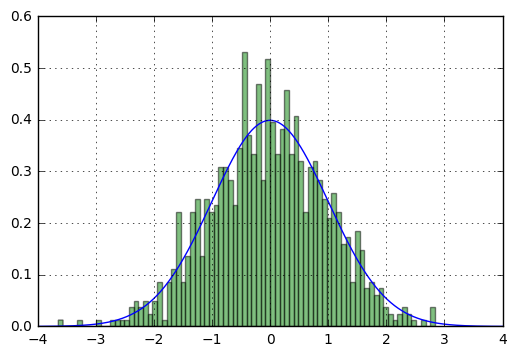

In [35]:
elements = CLT(checks_stats, theoretical_mean=C(n))
draw_frequencies_histogram(map(float, elements), bins=80,
                          pdf=lambda seq: (linspace(-4, 4, 1e3), Normal_fn))

finally, apply it to the average number of swaps:

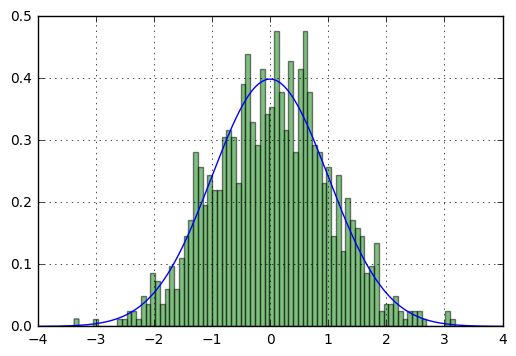

In [36]:
elements = CLT(swaps_stats, theoretical_mean=S(n))
draw_frequencies_histogram(map(float, elements), bins=80,
                          pdf=lambda seq: (linspace(-4, 4, 1e3), Normal_fn))

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.